In [1]:
library(grid)
library(rpart)
library(rpart.plot)
library(partykit)
library(lattice)
library(ggplot2)
library(caret)

In [2]:
set.seed(1)

In [3]:
invalids <- c('Time', 'Longitude', 'Latitude', 'Brake', 'Accel', 'flag', 'Curve100', 'Curve150', 'TimeHeadway')

In [4]:
printf <- function(...) cat(sprintf(...))

In [5]:
CV <- function(dfx, expr, verbose=FALSE) {        
    folds <- createFolds(dfx$flag)
    
    count <- 1
    errs <- c()
    reds <- c()
    blues <- c()
    for (ids in folds) {
        train <- dfx[-ids, ]
        test <- dfx[ids, ]
        # fit <- rpart(expr, data=train, method="class")
        fit <- rpart(expr, data=train, method="class", cp=0.017)
        p <- predict(fit, newdata=test)
        predictedFlags <- colnames(p)[max.col(p, ties.method = "first")]
        
        if (verbose) {            
            printf("Fold%d\n", count)
            result <- correctVsPredict(test, predictedFlags)
            reds <- c(reds, result[1])
            blues <- c(blues, result[2])
            count <- count + 1
            printf("\n")
        }
        
        nerr <- sum((predictedFlags == test$flag) == FALSE)
        errs <- c(errs, nerr / nrow(test))
    }
    
    return(c(mean(errs), mean(reds), mean(blues)))
}

In [6]:
correctVsPredict <- function(test, predictedFlags) {    
    # for All
    # nTests <- nrow(test)
    # nCorrectAll <- sum((predictedFlags == test$flag) == TRUE)
    # printf("As fo All: correct/all = %d/%d = %f\n", nCorrectAll, nTests, nCorrectAll / nTests)
    
    # for Red
    predictedRedRows <- test[predictedFlags == "Red", ]
    nCorrectReds <- sum((predictedRedRows$flag == 'Red') == TRUE)
    nPredictedReds <- nrow(predictedRedRows)
    printf("As for Red: correct/predict = %d/%d = %f\n", nCorrectReds, nPredictedReds, nCorrectReds / nPredictedReds)
    
    # for Blue
    predictedBlueRows <- test[predictedFlags == "Blue", ]
    nCorrectBlues <- sum((predictedBlueRows$flag == 'Blue') == TRUE)
    nPredictedBlues <- nrow(predictedBlueRows)
    printf("As for Blue: correct/predict = %d/%d = %f\n", nCorrectBlues, nPredictedBlues, nCorrectBlues / nPredictedBlues)
    
    c(nCorrectReds/nPredictedReds, nCorrectBlues/nPredictedBlues)
}

In [7]:
printRedRatios <- function(dfx) {
    nRed <- nrow(dfx[dfx$flag == "Red", ])
    nAll <- nrow(dfx)
    printf("Red/All = %d/%d = %f\n", nRed, nAll, nRed/nAll)
    printf("1 - Red/All = %d/%d = %f\n", nAll - nRed, nAll, 1 - nRed/nAll)
}

In [8]:
createFormula <- function(invalids, allFeatures) {
    isValidColumn <- function(x) ! x %in% invalids
    
    features <- Filter(isValidColumn, allFeatures)
    return(paste("flag ~ ", paste(features, collapse=" + ")))
}

# Predict Red

In [9]:
df3 <- read.csv("../data/middle/sp5.csv", stringsAsFactors=FALSE)

In [10]:
df3$flag[df3$flag == "RedA"] <- "Red"
df3$flag[df3$flag == "RedB"] <- "Red"
df3$flag[df3$flag == "BlueA"] <- "Blue"
df3$flag[df3$flag == "BlueB"] <- "Blue"
df3$flag <- as.factor(df3$flag)

In [11]:
allFeatures <- c(colnames(df3))
expr <- createFormula(invalids, allFeatures)

In [12]:
result <- CV(df3, expr, verbose=TRUE)
printRedRatios(df3)
printf("Red: Mean correct/predict = %f\n", result[2])
printf("Blue: Mean correct/predict = %f\n", result[3])
printf("CV value: %f", result[1])

Fold1
As for Red: correct/predict = 51/74 = 0.689189
As for Blue: correct/predict = 21/30 = 0.700000

Fold2
As for Red: correct/predict = 48/73 = 0.657534
As for Blue: correct/predict = 20/32 = 0.625000

Fold3
As for Red: correct/predict = 53/82 = 0.646341
As for Blue: correct/predict = 16/22 = 0.727273

Fold4
As for Red: correct/predict = 49/75 = 0.653333
As for Blue: correct/predict = 19/29 = 0.655172

Fold5
As for Red: correct/predict = 49/77 = 0.636364
As for Blue: correct/predict = 17/27 = 0.629630

Fold6
As for Red: correct/predict = 40/64 = 0.625000
As for Blue: correct/predict = 21/40 = 0.525000

Fold7
As for Red: correct/predict = 47/73 = 0.643836
As for Blue: correct/predict = 19/32 = 0.593750

Fold8
As for Red: correct/predict = 40/58 = 0.689655
As for Blue: correct/predict = 27/46 = 0.586957

Fold9
As for Red: correct/predict = 49/81 = 0.604938
As for Blue: correct/predict = 13/23 = 0.565217

Fold10
As for Red: correct/predict = 46/75 = 0.613333
As for Blue: correct/predict

In [13]:
fit3 <- rpart(expr, data=df3, method="class")

In [14]:
fit3$cptable[which.min(fit3$cptable[,"xerror"]),"CP"]

[1] 0.01410542

In [15]:
printcp(fit3)


Classification tree:
rpart(formula = expr, data = df3, method = "class")

Variables actually used in tree construction:
 [1] AccelerationSpeed AheadDistance     Curve             CurveAverage     
 [5] DiffAvgSpeed      DistManBicycle    DistSignal        EmptinessOfRoad  
 [9] MaxSpeed          Pitch             RiskFactor        RoadFactor       
[13] Speed             TimeToCollision  

Root node error: 449/1042 = 0.4309

n= 1042 

         CP nsplit rel error  xerror     xstd
1  0.064588      0   1.00000 1.00000 0.035602
2  0.051225      1   0.93541 0.93764 0.035278
3  0.048998      2   0.88419 0.93096 0.035237
4  0.022272      3   0.83519 0.88196 0.034897
5  0.020045      6   0.76169 0.88196 0.034897
6  0.014105      7   0.74165 0.84633 0.034605
7  0.013363     10   0.69933 0.88419 0.034914
8  0.011136     11   0.68597 0.89532 0.034996
9  0.010022     16   0.63029 0.89087 0.034964
10 0.010000     18   0.61024 0.88641 0.034930


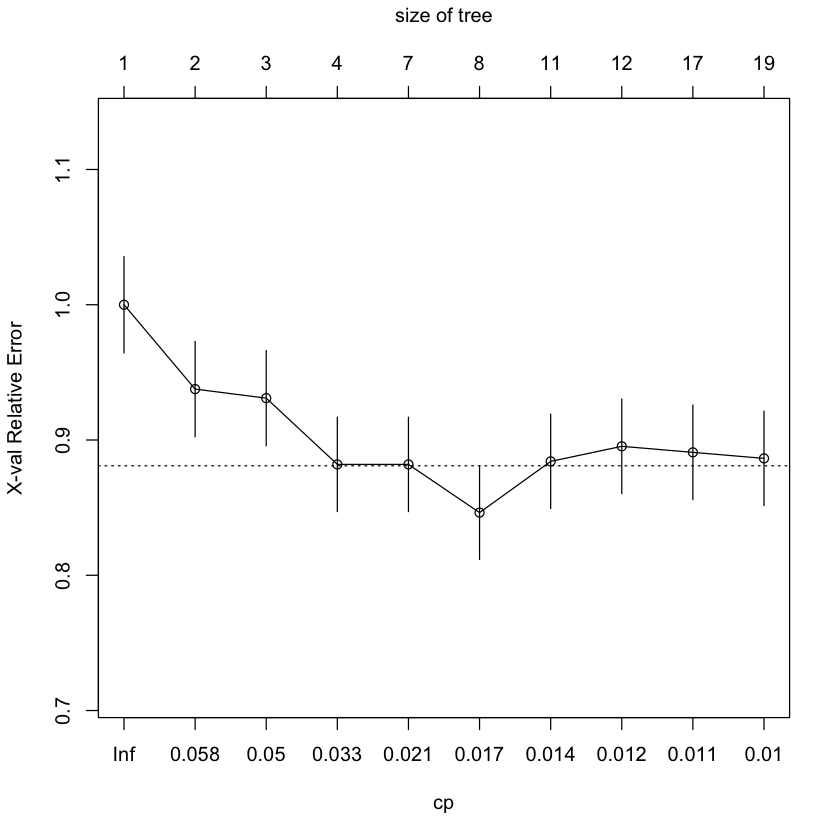

In [16]:
# png("DTree-cp.png", height=960, width=960, res=144)
plotcp(fit3)
# dev.off()

In [17]:
summary(fit3)

Call:
rpart(formula = expr, data = df3, method = "class")
  n= 1042 

           CP nsplit rel error    xerror       xstd
1  0.06458797      0 1.0000000 1.0000000 0.03560167
2  0.05122494      1 0.9354120 0.9376392 0.03527822
3  0.04899777      2 0.8841871 0.9309577 0.03523711
4  0.02227171      3 0.8351893 0.8819599 0.03489664
5  0.02004454      6 0.7616927 0.8819599 0.03489664
6  0.01410542      7 0.7416481 0.8463252 0.03460514
7  0.01336303     10 0.6993318 0.8841871 0.03491362
8  0.01113586     11 0.6859688 0.8953229 0.03499635
9  0.01002227     16 0.6302895 0.8908686 0.03496369
10 0.01000000     18 0.6102450 0.8864143 0.03493046

Variable importance
     CurveAverage             Speed          RoadType   EmptinessOfRoad 
               10                 9                 9                 8 
     DiffAvgSpeed     AheadDistance        RiskFactor   TimeToCollision 
                7                 7                 6                 6 
            Curve   AverageVelocity          

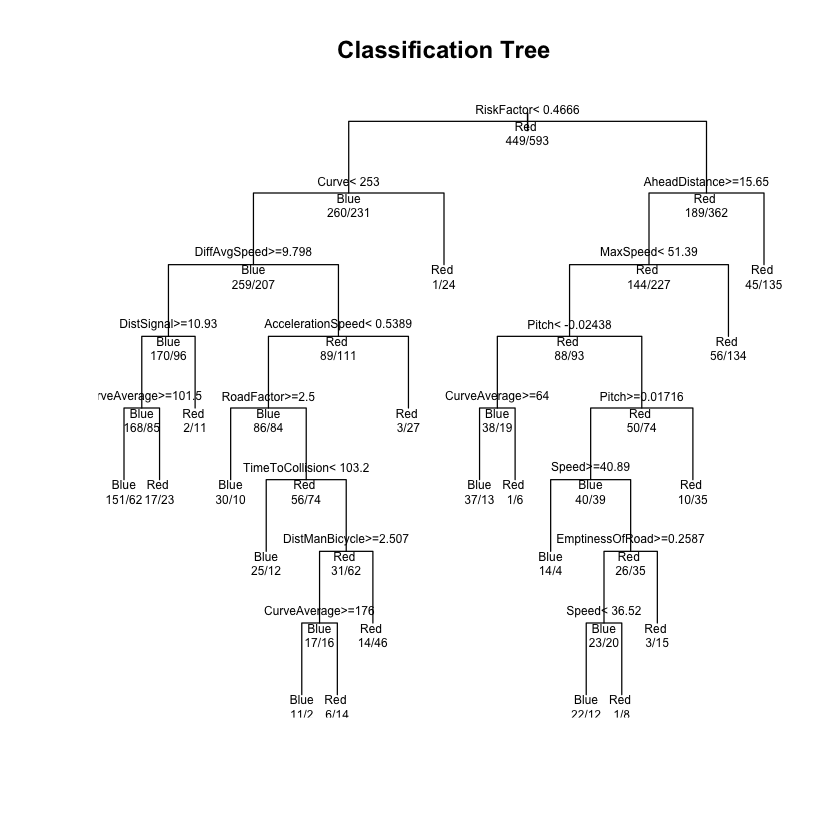

In [18]:
# png("DTree.png", height=960, width=960, res=144)
plot(fit3, uniform=TRUE, main="Classification Tree")
text(fit3, use.n=TRUE, all=TRUE, cex=.6)
# dev.off()